# PyTorch チュートリアル
機械学習でよく使われるライブラリ PyTorch について、最低限使えるように簡単にご紹介します。

データ読み込みから学習・検証まで一通りの流れを分かってもらえればOKです。

なお、このチュートリアルは以下のサイトを参考にしているので、もっと詳しく知りたい方は参照してください！

https://yutaroogawa.github.io/pytorch_tutorials_jp/

## PyTorch とは？
PyTorch は Python 用の科学計算ライブラリです。

Tensor と呼ばれる多次元配列を計算に利用しています。この Tensor に対して、転置や線形代数、乱数処理など機械学習分野で使いやすい機能が色々と用意されています。

In [16]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.5472, 0.3653, 0.2602],
        [0.6732, 0.0435, 0.5931],
        [0.5837, 0.1073, 0.4497],
        [0.5634, 0.8252, 0.9433],
        [0.1973, 0.6411, 0.0516]])


## Autograd (自動微分)
PyTorch によるニューラルネットワーク構築の土台となっているのが、autograd 機能です。

ニューラルネットワークでは入力の Tensor に対して、重みをかけたり、正規化したりなどの一連の計算を行って出力を得ます。

Tensor はこの一連の計算処理をデータとして記録・保持しているため、勾配を計算することができます。

In [17]:
x = torch.rand(2, 2, requires_grad=True)
print(x)

tensor([[0.5079, 0.3344],
        [0.5936, 0.6525]], requires_grad=True)


In [18]:
def f(x):
    return (x ** 2).mean()

y = f(x)
print(y)

tensor(0.2870, grad_fn=<MeanBackward0>)


In [19]:
print(x.grad)
y.backward()
print(x.grad)

None
tensor([[0.2540, 0.1672],
        [0.2968, 0.3263]])


上の例のように

$y=f(x)$

に対して、y.backward の実行によって x の勾配を計算できる。

## 実際の学習の流れ：クラス分類を例に
実際、データを読み込んで学習を回すまでの流れを説明します。

## データの読み込み
今回は CIFAR10 データセットという画像の 10 クラス分類用のデータセットを用います。

以下ではデータセットを読み込んで Tensor にしています。

In [20]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


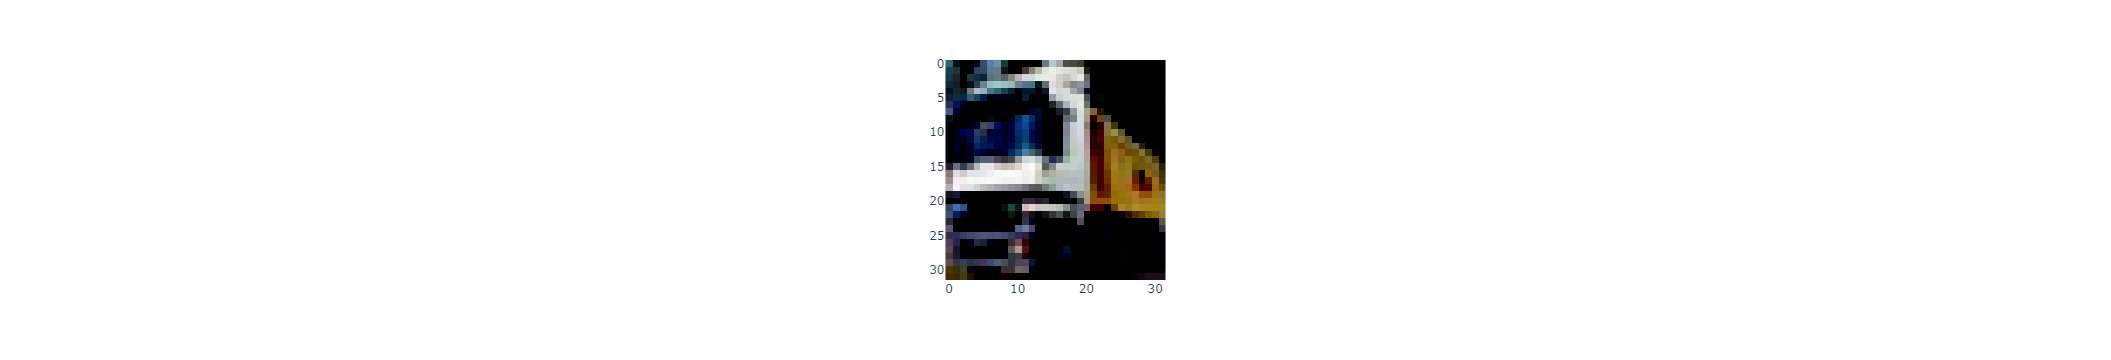

truck


In [21]:
# データセットの画像例
import plotly.express as px
import numpy as np

image, label = trainset[1]
fig = px.imshow(np.transpose(image, (1, 2, 0)))
fig.show()
print(classes[label])

## データローダーの作成
データは学習時にはミニバッチと呼ばれる複数データのセットとして利用されます。

データセットを元にバッチを提供するのが DataLoader です。

In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

## モデルの定義
ここまで、データの準備が整ったのでモデルの定義をします。

今回は畳み込みニューラルネットワーク（CNN）を定義して利用します。

モデルの定義では、初期化処理でネットワークを定義し、forward メソッドで実際の入力を出力に変えるまでの各層の処理を書くことが多いです。

[PyTorch の各層](https://pytorch.org/docs/stable/nn.html)

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 損失関数の定義
損失関数は、（出力、目標）のペアを入力に、ニューラルネットワークの出力（output）が目標（target）からどれくらい乖離しているかを推定する値を計算します。

[PyTorch の損失関数](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [24]:
criterion = nn.CrossEntropyLoss() # クロスエントロピー誤差関数

## オプティマイザの定義
計算した損失を元にパラメタの最適化を行います。

この最適化を行う際の更新則を決めるのがオプティマイザです。

[PyTorch のオプティマイザ](https://pytorch.org/docs/stable/optim.html)

In [25]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01) # 確率勾配降下（SGD）

## モデルの学習
繰り返しデータをモデルに与えて、最適化を行っていきます。

In [26]:
for epoch in range(1):  # エポック数分ループを回します

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データセットのデータを [inputs, labels]の形で取得
        inputs, labels = data

        # パラメータの勾配をリセット
        optimizer.zero_grad()

        # 順伝搬＋逆伝搬＋パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報の表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2,000ミニバッチにつき1度表示
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.254
[1,  4000] loss: 1.963
[1,  6000] loss: 1.743
[1,  8000] loss: 1.595
[1, 10000] loss: 1.538
[1, 12000] loss: 1.476
Finished Training


In [27]:
# 学習したパラメタの保存
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## テスト
学習したモデルの汎化性能を確認するために、学習に用いていないテストデータを用いて評価を行います。

In [28]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) # output はある画像が得られたとき、あるクラスである条件付確率です
        _, predicted = torch.max(outputs.data, 1) # 確率が最も高いクラスを取得し、ラベルと比較します
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


ランダムで選んだ場合、クラスを当てられる確率は 10 % なのでちゃんと学習できていることが分かります。

チュートリアルは以上です！おつかれさまでした！